In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sb
import matplotlib.ticker as ticker
import scipy.stats as sp
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import scipy
import math

import xgboost as xgb
from xgboost import plot_importance, plot_tree

%matplotlib inline

In [2]:
sample_df = pd.read_csv("Prepared_dataset.csv")
sample_df['date']  = pd.to_datetime(sample_df['date'], format = '%Y-%m-%d')
sample_df = sample_df.set_index('date')

In [3]:
end_date = '01-Mar-2022'

### Synthetically projecting Vaccination ratio

- We know that vaccination has started roughly from Jan-2021. We use these dates to fit the linear regression model from Jan-2021 until 01-May-2021
- From 01-May-2021 until Jun-23 we can see the models performance on this test set

In [4]:
start_date = '01-Jan-2021'
vaccination_df = sample_df.loc[sample_df.index>=start_date].copy()

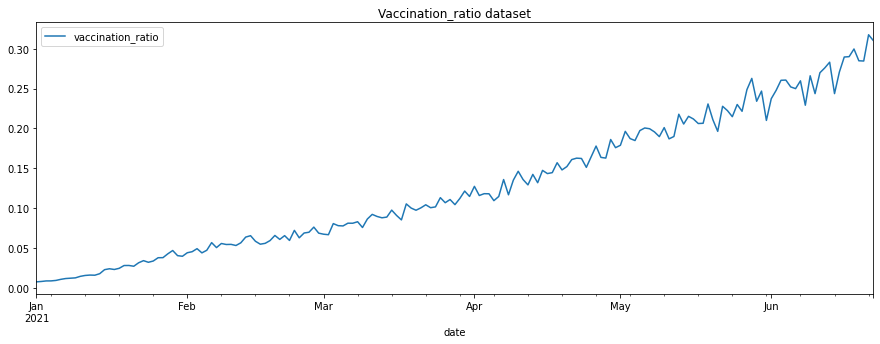

In [5]:
vaccination_df = vaccination_df.drop(['new_deaths_per_million','reproduction_rate','positive_rate','stringency_index'],axis=1)

_ = vaccination_df.plot(figsize=(15,5), title='Vaccination_ratio dataset')

In [6]:
# To have a reference from a start date 
vaccination_df['days_from_start'] = (vaccination_df.index - vaccination_df.index[0]).days

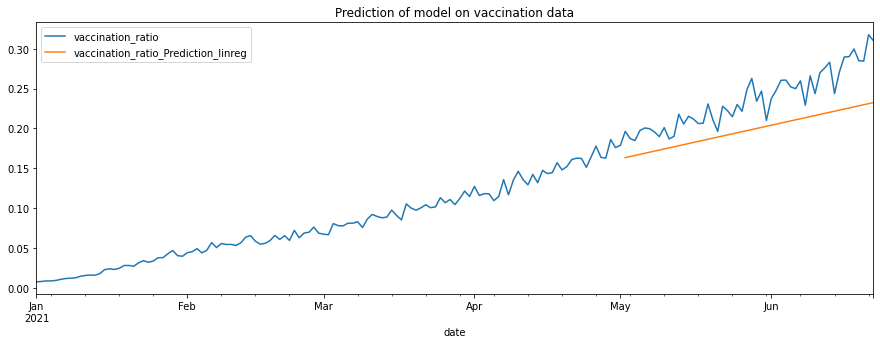

In [7]:
split_date = '01-May-2021'
vaccination_df_train = vaccination_df.loc[vaccination_df.index <= split_date].copy()
vaccination_df_test = vaccination_df.loc[vaccination_df.index > split_date].copy()

X_train = vaccination_df_train.drop(['vaccination_ratio'],axis=1)
y_train = pd.DataFrame(vaccination_df_train['vaccination_ratio'])

X_test = vaccination_df_test.drop(['vaccination_ratio'],axis=1)
y_test = pd.DataFrame(vaccination_df_test['vaccination_ratio'])

model = linear_model.LinearRegression().fit(X_train, y_train)#
vaccination_df_test['vaccination_ratio_Prediction_linreg'] = model.predict(X_test) 

vaccination_df_all = pd.concat([vaccination_df_train,vaccination_df_test], sort=False)
_ = vaccination_df_all[['vaccination_ratio','vaccination_ratio_Prediction_linreg']].plot(figsize=(15, 5),title="Prediction of model on vaccination data")

> We see that vaccination ratio is not exactly linear. It is more of exponential. This can b explained by the fact that there are more vaccination drives happening and people are getting vaccinated faster w.r.t time
> Alternative is to go ahead to fit the vaccation_ratio using a simple Neural network which can handle curves
   - The vaccination ratio has a max_limit of 1, so we can go ahead and use a sigmoid function in our final layer of NN
   - The hidden layer

In [8]:
days = pd.date_range(start='2021-06-22', end=end_date)
future_projections = pd.DataFrame(data=days, index = range(len(days)), columns=['date'])
future_projections = future_projections.set_index('date')
#projection_10_months = vaccination_df.append(projection_10_months)

In [9]:
future_projections['days_from_start'] = (future_projections.index - vaccination_df.index[0]).days
visualization_df = future_projections.copy()
future_projections['vaccination_ratio'] = model.predict(future_projections) 

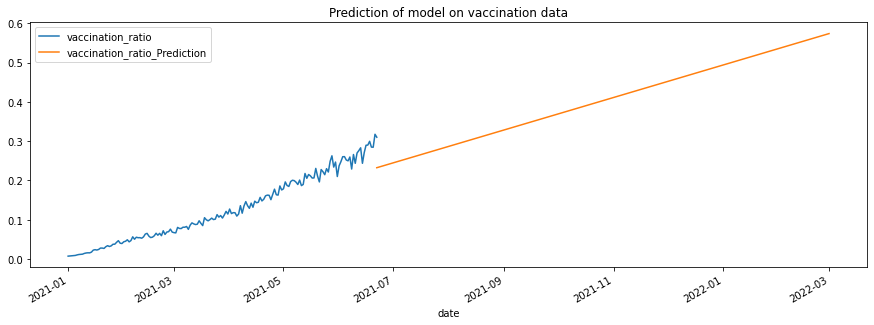

In [10]:
# We create a separate dataframe so that we can visualize it
visualization_df['vaccination_ratio_Prediction'] = model.predict(visualization_df) 
visualization_df = vaccination_df.append(visualization_df)
_ = visualization_df[['vaccination_ratio','vaccination_ratio_Prediction']].plot(figsize=(15, 5),title="Prediction of model on vaccination data")

This is our synthetic data, however this can be improved by using a simple neural network to capture the non linearity mentioned previously. 

In [11]:
vaccination_ratio_future_projections = future_projections

### Synthetically projecting Stringency Index


In [12]:
future_projections.insert(loc=2,column='stringency_index',value=[0.0]*len(future_projections))

In [13]:
stringency_df = sample_df.drop(sample_df.columns.difference(['stringency_index']), 1, inplace=False)

In [14]:
from pmdarima import auto_arima
  
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


## We try to find the best arima model for our data
# Fit auto_arima function to our dataset
stepwise_fit = auto_arima(stringency_df['stringency_index'], start_p = 1, start_q = 1,
                          max_p = 5, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1363.800, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1191.180, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1123.744, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1326.621, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1233.661, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.15 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1212.761, Time=0.20 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1105.956, Time=0.51 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1316.252, Time=0.13 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=inf, Time=1.81 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=1216.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  539
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -480.332
Date:                              Sat, 26 Jun 2021   AIC                            970.664
Time:                                      21:00:35   BIC                            991.991
Sample:                                           0   HQIC                           979.014
                                              - 539                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2539      0.027      9.434      0.000       0.201       0.307
ma.L2          0.2631      0.020     13.366      0.000       0.225       0.302
ma.L3          0.5204      0.029     17.692      0.000       0.463       0.578
ma.S.L12      -0.8807      0.034    -26.190      0.000      -0.947      -0.815
sigma2         0.3509      0.010     36.923      0.000       0.332       0.370
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):              8609.00
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see that the best model is a [ SARIMAX model ]

In [15]:

split_date = '01-Jun-2021'
stringency_df_train = stringency_df.loc[stringency_df.index <= split_date].copy()
stringency_df_test = stringency_df.loc[stringency_df.index > split_date].copy()

# Fit a SARIMAX(0, 1, 3)x(0, 1, [1], 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(stringency_df_train['stringency_index'], 
                order = (0, 1, 3), 
                seasonal_order =(0, 1, [1], 12))
  
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     stringency_index   No. Observations:                  518
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -445.851
Date:                              Sat, 26 Jun 2021   AIC                            901.703
Time:                                      21:00:36   BIC                            922.825
Sample:                                  01-01-2020   HQIC                           909.988
                                       - 06-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2675      0.026     10.412      0.000       0.217       0.318
ma.L2          0.2889      0.020     14.548      0.000       0.250       0.328
ma.L3          0.5134      0.027     18.746      0.000       0.460       0.567
ma.S.L12      -0.8925      0.039    -22.721      0.000      -0.970      -0.816
sigma2         0.3290      0.011     28.739      0.000       0.307       0.351
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):              7988.41
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                             2.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Check performance against test set

<AxesSubplot:xlabel='date'>

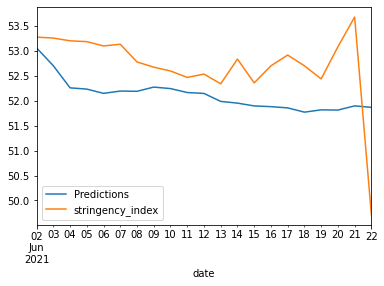

In [16]:
start = len(stringency_df_train)
end = len(stringency_df_train) + len(stringency_df_test) - 1
  
# Predictions against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
stringency_df_test['stringency_index'].plot(legend = True)

Here we can see that the SARIMAX model has gathered a trend in our data, we now use this model to forecast future stringency_index

2021-06-23    51.790031
2021-06-24    51.771781
2021-06-25    51.611657
2021-06-26    51.577481
2021-06-27    51.520899
                ...    
2022-02-26    43.899959
2022-02-27    43.895360
2022-02-28    43.979936
2022-03-01    43.949724
2022-03-02    43.870787
Freq: D, Name: Predictions, Length: 253, dtype: float64

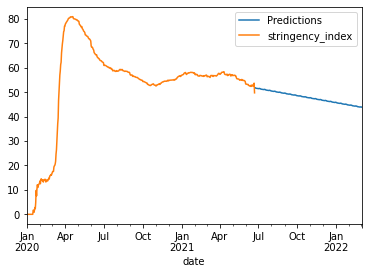

In [17]:

start = len(stringency_df)
end = len(stringency_df)+len(future_projections) - 1
  
# Predictions against the test set
stringency_predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
stringency_predictions.plot(legend = True)
stringency_df['stringency_index'].plot(legend = True)


result.predict(start, end,typ = 'levels').rename("Predictions")

- Well this what the future holds for us in terms of Stringency_index

We now use these projected values future_projections_df

In [18]:
future_projections['stringency_index'] = stringency_predictions

In [19]:
future_projections

,days_from_start,vaccination_ratio,stringency_index
date,,,
2021-06-22,172,0.232506,NaN
2021-06-23,173,0.233860,51.790031
2021-06-24,174,0.235214,51.771781
2021-06-25,175,0.236568,51.611657
2021-06-26,176,0.237922,51.577481
...,...,...,...
2022-02-25,420,0.568253,43.853864
2022-02-26,421,0.569607,43.899959
2022-02-27,422,0.570961,43.895360
